In [1]:
import numpy as np
import matplotlib as plt
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

house_data=pd.read_csv('~/Downloads/housepricedata.csv')



Splitting and normalising the normalised Data:

In [2]:
def split_train_test(data,test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(test_ratio*len(data))
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]
    

training_data,testing_data=split_train_test(house_data,0.2)
X_train=training_data.drop(['AboveMedianPrice'],axis=1)
Y_trainl=training_data['AboveMedianPrice']
Y_train=pd.DataFrame(Y_trainl)



#Normalising training data:

X_train=(X_train-X_train.mean())/X_train.std()

#converting dataframes to numpy arrays:

x=X_train.to_numpy()
y=Y_train.to_numpy()


X_test=testing_data.drop(['AboveMedianPrice'],axis=1)
Y_testl=testing_data['AboveMedianPrice']
Y_test=pd.DataFrame(Y_testl)

#normalising testing data:

X_test=(X_test-X_test.mean())/X_test.std()

#converting dataframes to numpy arrays:

x_test=X_test.to_numpy()
y_test=Y_test.to_numpy()


Initialization of weight paramters using a dict which stores parameters for each layer:

In [3]:
def Initialisation(layers):
    parameters={}
    L=len(layers)
    print('Enter which distribution do you want to use to initialise the parameters (gaussian/uniform):')
    distr=str(input())
    for l in range(1,L):
        if(distr=='gaussian'):
            parameters['W'+str(l)]=np.random.normal(0,1,(layers[l],layers[l-1]))
        if(distr=='uniform'):
            parameters['W'+str(l)]=np.random.uniform(0,1,(layers[l],layers[l-1]))
        
        parameters['b'+str(l)]=np.zeros([layers[l],1])
    return parameters

Defining activation functions and their derivatives:

In [4]:
def Relu(Aa):
    return np.maximum(Aa,0)
def DRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def sig(a):
    return (1/(1+np.exp(-a)))
def Dsig(a):
    return a*(1-a)

def tanh(x):
    t=np.tanh(x)
    return t
def Dtanh(x):
    dt=1-x**2
    return dt
    

Defining the function for calculating activations from the parameters, in this a list cache is used to store the values for the activation passed, the next layer activation calculated and the parameters W and b. This cache is used in back propagation function to pass the values required for a particular layer. 

In [5]:


def linear_forward(z_prev,W,b,activation):                       
    a=W.dot(z_prev)+b
    if activation=='ReLu':
        z=Relu(a)
    elif activation=='sig':
        z=sig(a)
    elif activation=='tanh':
        z=tanh(a)
    act_cache=(z,z_prev,W,b)
    return z,act_cache

Using cross entropy loss:

In [6]:
def costfunc(z_final,y):
    eps=10**-8
    L=-np.log(z_final+eps).dot(y)-np.log(1-z_final+eps).dot(1-y)
    L=np.squeeze(L)
    return L

Function for calculating all activations in forwards propagation:

In [7]:
def fwd_prop(layers,parameters,z_prev,activ):  
    
    
    caches=[]
    for j in range(1,len(layers)):
        W=parameters["W"+str(j)]
        b=parameters["b"+str(j)]
        if(j!=(len(layers)-1)):
            if(activ=='Relu'):
                z_prev,cach=linear_forward(z_prev,W,b,'ReLu')
                
            elif(activ=='tanh'):
                z_prev,cach=linear_forward(z_prev,W,b,'tanh')
                
            elif(activ=='sig'):
                z_prev,cach=linear_forward(z_prev,W,b,'sig')
        
        #For final layer only sigmoid is used:
        elif(j==(len(layers)-1)):
            z,cach=linear_forward(z_prev,W,b,'sig')
            y_pred=z
          
        caches.append(cach)

    return caches,y_pred

Defining a dictionary grads which will be used to update the parameters:

In [8]:

def gradients(layers):
    parameters={}
    L=len(layers)
    for l in range(1,L):
        grads['W'+str(l)]=np.zeros([layers[l],layers[l-1]])
        grads['b'+str(l)]=np.zeros([layers[l],1])
    return grads

Using back propagation to update our params. In this we input caches containing the activations for a layer (the activation of that layer and the previous layer just before that), and the parameters W and b for the respective layers.



In [9]:
def back_prop(caches,y,layers,activ):
    current_cache=caches[-1]
    z,z_prev,W,b=current_cache
    
    dz_final=(z-y.T)
    da_final=np.multiply(dz_final,Dsig(z))
    dw_final=da_final.dot(z_prev.T)
    db_final=np.sum(da_final,axis=1)
    db_final.resize(layers[len(layers)-1],1)
    
    grads['W'+str(len(caches))]=dw_final
    grads['b'+str(len(caches))]=db_final
    act_cache=[None]*(len(caches))
    da=da_final
    dz=W.T.dot(da)
    act_cache[len(caches)-1]=(dz) 
    
    for i in range(1,len(caches)):
        dz=act_cache[len(caches)-i]
        current_cache=caches[-1-i]
        z,z_prev,W,b=current_cache
        
        if(activ=='Relu'):
            da=dz*DRelu(z)
        elif(activ=='tanh'):
            da=dz*Dtanh(z)
        elif(activ=='sig'):
            da=dz*Dsig(z)
        dz=W.T.dot(da)
            
        grads['W'+str(len(caches)-i)]=da.dot(z_prev.T)
        grads['b'+str(len(caches)-i)]=np.sum(da,axis=1)
        grads['b'+str(len(caches)-i)].resize(layers[len(layers)-1-i],1)
        act_cache[len(caches)-1-i]=(dz)
    return grads

In [10]:

def update_paras(learning_rate,grads):
    L=len(layers)
    for l in range(1,L):
        parameters['W'+str(l)]=parameters['W'+str(l)]-learning_rate*grads['W'+str(l)]
        parameters['b'+str(l)]=parameters['b'+str(l)]-learning_rate*grads['b'+str(l)]
      
    return parameters

In [11]:
caches=[]
grads={}
parameters={}
layers=[]
costs=[]
iterations=[]
print("Enter number of layers:")
n=int(input())
i=0
print("Enter the number of units in the layers after the input layer:")
layers.append(x.shape[1])
for i in range(1,n):
    k=int(input())
    layers.append(k)
    
print("Enter activation functions for all layers before the final layer(Relu/tanh/sig):")
activ=str(input())
parameters=Initialisation(layers)
grads=gradients(layers)
print('Enter the learning rate:')
l_r=float(input())
z_prev=x.T
for i in range(20000):
    caches,y_pred=fwd_prop(layers,parameters,z_prev,activ)
    grads=back_prop(caches,y,layers,activ)
    update_paras(l_r,grads)
    if(i%100==0):
        l=costfunc(y_pred,y)
        costs.append(l)
        iterations.append(i)

Enter number of layers:
5
Enter the number of units in the layers after the input layer:
20
30
15
10
Enter activation functions for all layers before the final layer(Relu/tanh/sig):
tanh
Enter which distribution do you want to use to initialise the parameters (gaussian/uniform):
gaussian
Enter the learning rate:
0.001


 for training data:
 accuracy: 94.86301369863014 %
 F1 score: 0.9480069324090122

 for testing data:
 accuracy: 88.69863013698631 %
 F1 score: 0.8938906752411576



<function matplotlib.pyplot.show(*args, **kw)>

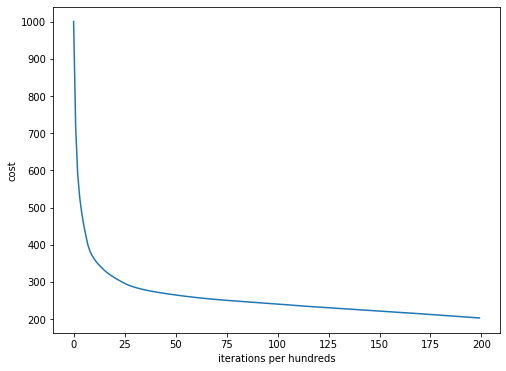

In [41]:
def predict(xx,yy,layerss,parameterss):
    m=yy.shape[1]
    Y_prediction = np.zeros([1,m])
    temp=[]
    temp,y_prediction=fwd_prop(layerss,parameterss,xx,activ)
    for i in range(y_prediction.shape[1]):
        Y_prediction[0,i] = 1 if y_prediction[0,i]>0.5 else 0
   
    print(" accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction - yy)) * 100))   
    
    def my_precision_score(actual, predicted):
        true_positives = len([a for a, p in zip(actual, predicted) if a == p and p == 1])
        false_positives = len([a for a, p in zip(actual, predicted) if a != p and p == 1])
        return true_positives / (true_positives + false_positives)

    def my_recall_score(actual, predicted):
        true_positives = len([a for a, p in zip(actual, predicted) if a == p and p == 1])
        false_negatives = len([a for a, p in zip(actual, predicted) if a != p and p == 0])
        return true_positives / (true_positives + false_negatives)


    def my_f1_score(actual, predicted):
        return 2 * (my_precision_score(actual, predicted) * my_recall_score(actual, predicted)) / (my_precision_score(actual, predicted) + my_recall_score(actual, predicted))

    print(" F1 score:", my_f1_score(np.squeeze(yy), np.squeeze(Y_prediction)))

    
    return Y_prediction

print(" for training data:")
trained=predict(x.T,y.T,layers,parameters)
print("")

print(" for testing data:")
tested=predict(x_test.T,y_test.T,layers,parameters)
print("")

plt.figure(figsize=(8,6))
plt.plot(np.squeeze(costs))
plt.xlabel('iterations per hundreds')
plt.ylabel('cost')
plt.show